Code adapted from: https://github.com/JackMurdochMoore/power-law

associated to: 
J. M. Moore, G. Yan, E. G Altmann, "Nonparametric Power-Law Surrogates", <a href="https://doi.org/10.1103/PhysRevX.12.021056"> 
Phys. Rev. X 12, 021056 (2022) </a>

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
cmap = cm.tab10

In [2]:
## custom packages
src_dir = os.path.join(os.pardir,'src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext, determine_tau
from powerlaw_fit import *

# import setup for figure layout (see src/modules_plotting.py to customize)
from modules_plotting import * 

sys.path.append("./src/")
from constrained_power_law_surrogates import gen_typ_p_l_surrogate, gen_power_law_surr_list, ident_cut_off_const, plot_surr_seq, hypothesis_test, ks_stat, cond_ent_o_1, cond_ent_o_2

# Generate dataset:

We generate synthetic data that follows a power-law:

$p(x) \propto x^{-\gamma }$.

The data is generated using a Markov-process such that we can include correlations via a paramter $\mu$.

For $\mu = 1$, we recover the case of independently sampled data. 

In [110]:
label = 'mcmc_zipf'
k = 10 ## number of neighbors for correlated step
Ntypes = 10000 ## maximum number of symbols
Ntokens = 1000 ## number of samples
alpha = 1.7 ## powerlaw exponent
mu = 0.05 ## correlation parameter
list_mu = [1.0,0.05] ## correlated and uncorrelated case


#correlated
dict_args = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':mu,
             'k':k,
             'src_dir':src_dir,
     }
x_data = get_xdata_ts_wrapper(label,dict_args)

#uncorreleated

dict_argsU = {'Ntypes':Ntypes,
             'Ntokens':Ntokens,
             'alpha':alpha,
             'mu':1.0,
             'k':k,
             'src_dir':src_dir,
     }
x_dataU = get_xdata_ts_wrapper(label,dict_argsU)



In [111]:
x_dataU

array([2, 1, 1, ..., 7, 1, 1])

In [112]:
seq = x_data

In [113]:
(x_min_KS, _, _, _, _) = ident_cut_off_const(seq)
print("Identified lower cut-off: " + str(x_min_KS))

Identified lower cut-off: 2


In [114]:
seq_L = [int(np.round(val)) for val in seq if val < x_min_KS]
print(seq_L)
seq_U = [int(np.round(val)) for val in seq if val >= x_min_KS]
print(seq_U)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [115]:
surrogate_methods = ['obse','know','cons','typi','boot','shuf','mark','ordi']
method_description={
    'obse':'Original observation',
    'know':'Power-law surrogate with known scale exponent',
    'cons':'Constrained power-law surrogate',
    'typi':'Typical power-law surrogate',
    'boot':'Bootstrap surrogate',
    'shuf':'Shuffle surrogate',
    'mark':'Constrained Markov order power-law surrogate',
    'ordi':'Constrained ordinal pattern power-law surrogate'
}
method_names = {
    'obse':'Observed',
    'know': 'Known exponent',
    'cons':'Constrained',
    'typi':'Typical',
    'boot':'Bootstrapped',
    'shuf':'Shuffled',
    'mark':'Markov',
    'ordi':'Ordinal pattern'
}

You can choose one of the methods to generate the surrogate of the input sequence *seq* as follows:

In [116]:
x_min = 1

In [117]:
print("Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=" + str(x_min_KS))
surr_seq_list = gen_power_law_surr_list(seq_U, surr_method='cons', x_min=x_min_KS)
print(surr_seq_list)

print("Using full input sequence seq and true lower cut-off x_min=" + str(x_min))
surr_seq_list = gen_power_law_surr_list(seq, surr_method='cons', x_min=x_min)
print(surr_seq_list)

Using sequence seq_U comprising values of input sequence above estimated lower cut-off x_min_KS=2
[[7, 6, 3, 5, 6, 2, 12, 5, 8, 2, 2, 2, 3, 336, 2, 2, 2, 2, 12, 8, 2, 2, 2, 2, 2, 8, 4, 2, 2, 16, 2, 1865, 1478, 373, 83, 149, 3852, 751, 31, 1486, 19, 373, 8, 2, 4, 2, 2, 2, 2, 2, 2, 13, 43, 3, 22, 86, 17, 17, 17, 85, 155, 124, 93, 26, 533, 104, 15, 86, 260, 92, 5, 10, 14, 141, 11, 11, 6, 3, 6, 10, 13, 68, 52, 492, 11, 66, 11, 76, 7, 14, 205, 6, 11, 6, 3, 10, 29, 22, 15, 6, 2, 2, 4, 4, 4, 3, 4, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 8, 8, 33, 11, 22, 2, 2, 44, 4, 3, 3, 2, 2, 22, 11, 5, 3, 4, 10, 12, 5, 10, 2, 6, 2, 2, 2, 5, 8, 2, 66, 10, 40, 6, 2, 3, 12, 4, 2, 3, 4, 2, 3, 6, 4, 4, 4, 5, 2, 3, 3, 3, 3, 6, 3, 3, 3, 9, 24, 13, 13, 5, 6, 5, 5, 51, 7, 23, 728, 31, 62, 17, 43, 7, 7, 3, 2, 4, 2, 2, 3, 3, 24, 3, 12, 3, 3, 6, 3, 2, 24, 4, 5, 25, 5, 3, 38, 171, 228, 2, 3, 65, 24, 10, 29, 21, 11, 19, 195, 58, 17, 10, 19, 11, 5, 74, 5, 30, 2, 2, 7, 24, 9, 5, 90, 2, 5, 3, 52, 35, 22, 4, 2, 2, 13, 10, 44, 11,

In [173]:
surr_cons = gen_power_law_surr_list(seq, surr_method='cons', x_min=x_min)
surr_shuf = gen_power_law_surr_list(seq, surr_method='shuf', x_min=x_min)
surr_mark = gen_power_law_surr_list(seq, surr_method='mark', x_min=x_min)
surr_ordi = gen_power_law_surr_list(seq, surr_method='ordi', x_min=x_min)
surr_typi = gen_power_law_surr_list(seq, surr_method='typi', x_min=x_min)



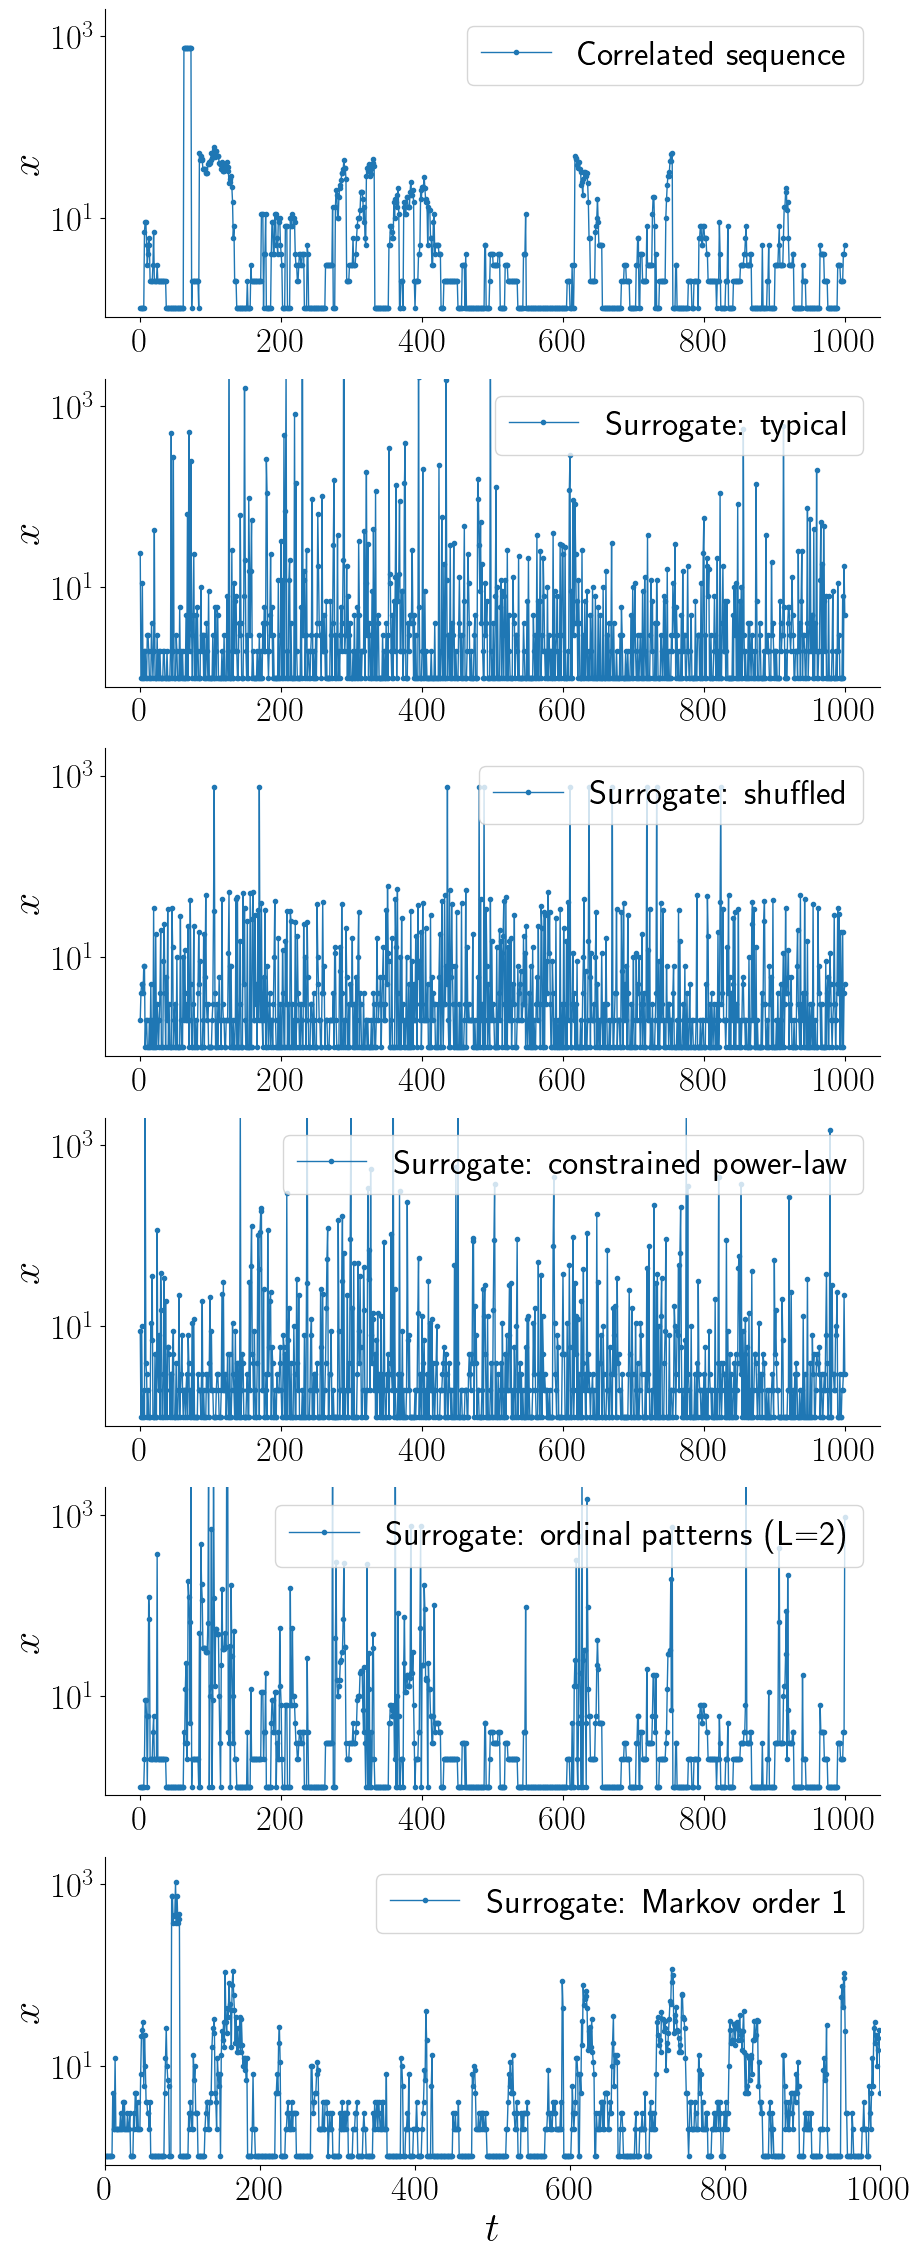

In [183]:
seqs=[seq,surr_typi[0],surr_shuf[0],surr_cons[0],surr_ordi[0],surr_mark[0]]
seqs_label=["Correlated sequence","Surrogate: typical","Surrogate: shuffled","Surrogate: constrained power-law","Surrogate: ordinal patterns (L=2)","Surrogate: Markov order 1"]
plt.rcParams['font.size'] = 30
fig, axs = plt.subplots(nrows=6, ncols=1,figsize=(10,28))#, figsize=fig_size)
    
plt.xlabel(r"$t$",fontsize=30)
plt.xlim(0,Ntokens)
plt.ylim(0.8,20000)
plt.yscale("log")
for i in range(len(seqs)):
    x=seqs[i]
    ax=axs[i]
    ax.set_yscale("log")
    ax.set_ylim(0.8,2000)
    ax.set_ylabel(r"$x$",fontsize=30)
    ax.plot(range(len(x)),x,".-",lw=1,label=seqs_label[i])
    ax.legend(loc=1,fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)

plt.savefig("fig/constrained1.png",dpi=300,bbox_inches='tight')
plt.show()

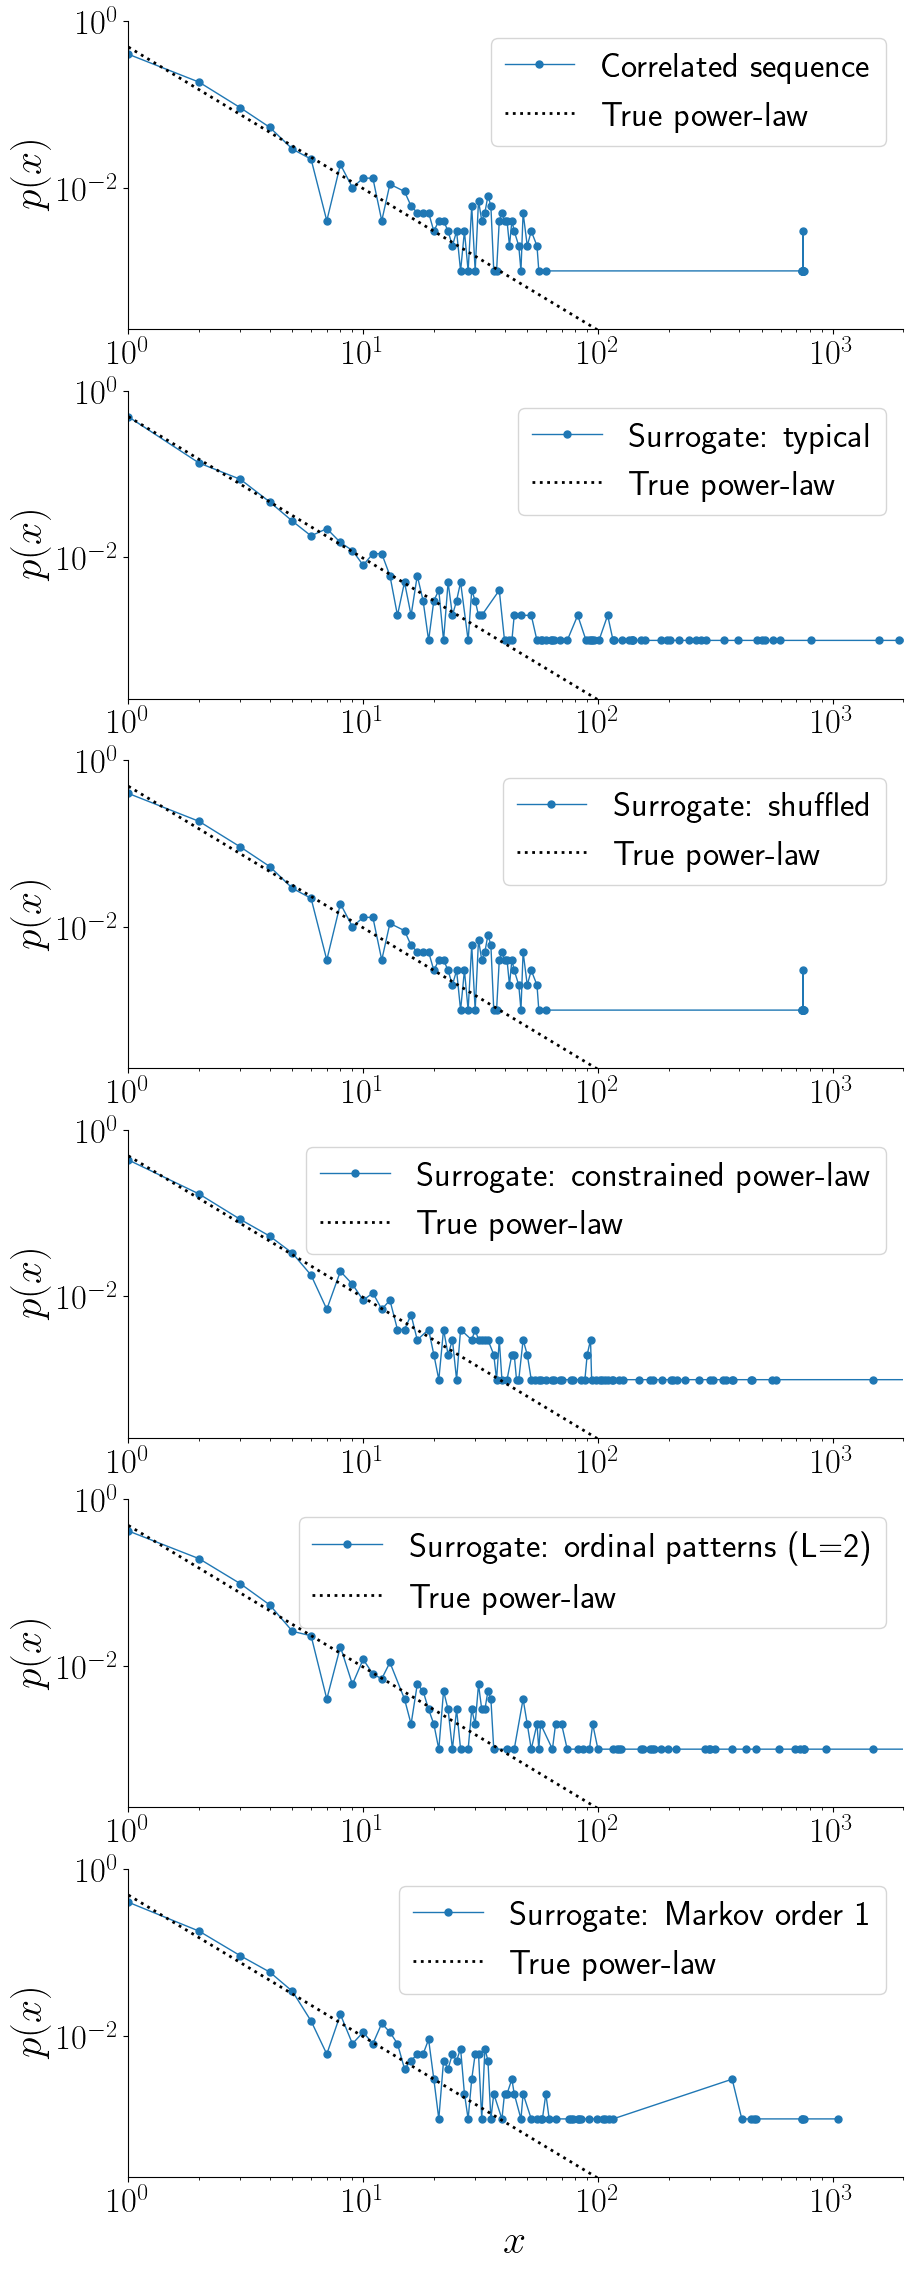

In [182]:
plt.rcParams['font.size'] = 30
fig, axs = plt.subplots(nrows=6, ncols=1,figsize=(10,28))#, figsize=fig_size)
    
plt.xlabel(r"$x$",fontsize=30)
for i in range(len(seqs)):
    ax=axs[i]
    
    x_data = seqs[i]

    xmin = 1
    xmax = Ntypes
    x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

    N = np.sum(nx)
    px = nx/N
    Fx = 1-np.cumsum(px)

    ## Plot the distribution
    x_ = x
    y_ = px

    c_ = cmap(0)
    ax.plot(x_,y_,marker='o',ms=5,lw=1,c = c_,label = seqs_label[i])


    ## Plot the truth
    c_ = 'black'
    x_ = np.arange(1,Ntypes+1,1)
    y_ = x_**(-alpha)
    y_ /= np.sum(y_)
    ax.plot(x_,y_,lw=2,c=c_, ls=':', label = r'True power-law')#: $\propto x^{-\gamma}, \gamma=$'+str(alpha))


    ## Layout stuff
    #ax.legend(loc='lower left')
    ax.legend(fontsize=25)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlim(1,2000)
    ax.set_ylim(2*10**(-4),1)

    #ax.set_xlabel(r'$x$')#,labelpad=0)
    ax.set_ylabel(r'$p(x)$',fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=25)

plt.savefig("fig/constrained2.png",dpi=300,bbox_inches='tight')
plt.show()